In [1]:
import Functions_data_analysis as fda
import Functions_load_output as flo
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
import matplotlib.path as mpath
from scipy import stats, signal
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

In [5]:
# Get recon data with anom ref 1979-2005

recon_dir = '../Climate_Data/LMR_output/'
# pace_recon = 'PACE_super_GKO1_all_linPSM_1mc_1900_2005_GISBrom_1880_2019_v10_sst'
pace2_recon = 'PAC_PACE2_super_GKO1_all_bilinPSM_1mc_1850_2005_GISBrom'
lme_recon = 'iCESM_LME_GKO1_linPSM_1mc_1800_2005_v10'
lens2_recon='LENS2_super_GKO1_all_bilinPSM_1mc_1850_2005_GISBrom'

recons = [lme_recon, lens2_recon, pace2_recon]
labs = ['CESM1-LME recon','CESM2-LENS recon','CESM2-PACE recon']


def get_recon_anom_data(recon_name,vname):
    """
    Gets gridded recon data from 1900 to 2005 in anomalies relative to 1979-2005.
    """
    recon_ds = xr.open_dataset(recon_dir+recon+'_'+vname+'.nc')
    recon_data = recon_ds.get(vname)
    recon_data_20th = recon_data.sel(time = slice(1900,2005))

    ref_data = recon_data.sel(time=slice(1979,2005)).mean(dim='time')
    recon_data_anom = recon_data_20th - ref_data

    recon_data_anom = recon_data_anom.squeeze()

    return recon_data_anom


recon_tas_dict = {}
recon_psl_dict = {}
recon_u10_dict = {}
recon_v10_dict = {}

for recon,lab in zip(recons, labs):

    recon_tas_dict[lab] = get_recon_anom_data(recon, 'tas')
    recon_psl_dict[lab] = get_recon_anom_data(recon, 'psl')/100
    recon_u10_dict[lab] = get_recon_anom_data(recon, 'u10')
    recon_v10_dict[lab] = get_recon_anom_data(recon, 'v10')

    

In [6]:
# Set up stats functions

def calc_corr(x,y):
    """
    x and y can be lists or arrays
    """
    #detrend data first
    x = signal.detrend(x)
    y = signal.detrend(y)
    
    #calculate sample correlation
    corr = stats.pearsonr(x,y)[0]
    corr_str = "{:.2f}".format(corr)
    
    #calculate number of independent obs n_eff
    autocorr_x = abs(stats.pearsonr(x[0:-1],x[1:])[0])
    autocorr_y = abs(stats.pearsonr(y[0:-1],y[1:])[0])
    n = len(x)
    n_eff = n * (1-autocorr_x * autocorr_y)/(1+autocorr_x * autocorr_y)
    
    #do t-test
    dof = n_eff -2
    t_stat = corr * np.sqrt(dof/(1-corr**2))
    p = stats.t.sf(np.abs(t_stat), dof)*2 
    #p_string = "{:.3f}".format(p)
    if p < 0.05:
        sig = '*'
    else:
        sig = ''
    
    return corr_str, sig

def calc_ce(x,v):
    """
    x = recon, v = verif
    can be lists or arrays. you convert them to np arrays
    """
    x = np.array(x)
    v = np.array(v)
    
    error = v - x
    
    # CE following equation 7 in Hakem et al., 2016
    numer = np.sum(np.power(error,2))
    denom = np.sum(np.power((v-np.mean(v)),2))
    CE    = 1 - (numer/denom)
    ce_str = '{:.2f}'.format(CE)
    
    return ce_str

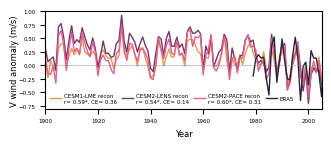

In [7]:
# Plot recon timeseries

shelf_v10_tseries = []
# region = 'naughten_shelf_box'
region = 'ase_domain'
#[-76.2,-71,245,260] for AS_near
lat1,lat2,lon1,lon2 = fda.analysis_region_dict[region]

fig,ax = plt.subplots()
fig.set_size_inches((3.25,1.5))
recon_years = recon_tas_dict[lab].time
fs = 8
colors = ["#e69b4b","#753669","#ED5A8D","#23293d"]

# get ERA5
era_v_fname = '../Climate_Data/ERA5/ERA5_annual_1979_2023_v10.nc'
ds = xr.open_dataset(era_v_fname)
ds = ds.isel(expver=0)
era_v = ds.v10
# era lat 90,...-90. lon -180,...,180.
era_v_reg = era_v.sel(latitude = slice(lat1,lat2),longitude=slice(lon1,lon2))
era_v_tseries = era_v_reg.mean(dim='longitude')
era_v_tseries = era_v_tseries.mean(dim='latitude')
era_v_ref = np.mean(era_v_tseries.sel(time=slice('1979','2005')))
era_v_anom = era_v_tseries - era_v_ref
era_years = np.arange(1979,2024,1)

# get recons
for lab,color in zip(labs,colors):

    recon_v10 = recon_v10_dict[lab]
    
    # calculate shelf v10
    recon_v10_reg = recon_v10.sel(lat=slice(lat2,lat1),lon=slice(180+(180+lon1),180+(180+lon2)))
    recon_v10_reg = recon_v10_reg.squeeze()
    recon_v10_tseries = recon_v10_reg.mean(dim='lon')
    recon_v10_tseries = recon_v10_tseries.mean(dim='lat')

    # calculate 1900-2005 trend and 1940s mag
    slope, intercept, r_value, p_value, std_err = stats.linregress(recon_years[50:], recon_v10_tseries[50:])
    mag_1940s = np.mean(recon_v10_tseries.sel(time=slice(1940,1941)))

    # calculate stats with ERA5
    start_idx = np.where(recon_years == 1979)[0][0]
    corr, sig = calc_corr(recon_v10_tseries[start_idx:],era_v_anom[0:27])
    ce = calc_ce(recon_v10_tseries[start_idx:],era_v_anom[0:27])
    stat_str_run = lab+'\nr= '+str(corr)+sig+', CE= '+ce

    # format label
    # uncomment to add trends to legend
    legend_lab = stat_str_run#+'\n {:.2f} m/s/cent'.format(slope*100) + '\n{:.2f} m/s'.format(mag_1940s)
    
    #plot
    ax.plot(recon_years,recon_v10_tseries,label=legend_lab,linewidth=1,color=color)

# Plot ERA5
ax.plot(era_years,era_v_anom,label='ERA5',color=colors[-1],linewidth=1)
# plot 0 line
ax.plot(np.arange(1850,2006,1),[0]*156,linestyle='--',color='gray',linewidth=0.4)

# format plot
ax.set_xlabel('Year',fontsize=fs-2)
ax.set_ylabel('V wind anomaly [m s⁻¹]',fontsize=fs-2,labelpad=-0.2)
# ax.set_title('a) Continental shelf meridional wind',fontsize=fs-1)
ax.set_xlim([1900,2005])
# ax.legend(loc='lower right', fontsize=fs-4, bbox_to_anchor=(1.3,-0.01), 
#           ncol=1, columnspacing=0.9, handletextpad=0.5, frameon=False)
ax.legend(loc='lower left', fontsize=fs-4, #bbox_to_anchor=(1.3,-0.01), 
          ncol=4, columnspacing=0.9, handletextpad=0.5, frameon=False)
ax.set_ylim([-0.8,1])
ax.tick_params(axis='x', labelsize=fs-4)
ax.tick_params(axis='y', labelsize=fs-4)

plt.subplots_adjust(top=0.86,bottom=0.21,left=0.12,right=.97)

# plt.savefig('Plots/Figure_5a_recon_vwind_tseries.png',dpi=600)


In [16]:
# Calculate trends

region_dict = {'ASL':[-80,-55,-160,-65.1], 'AS_near':[-76.5,-70,-120,-95]}

def calc_reg_trends(recon_data,region):

    lat1,lat2,lon1,lon2 = region_dict[region]
    lon1,lon2 = lon1+360, lon2+360
    years = recon_data.time
    recon_reg_data = recon_data.sel(lat = slice(lat1,lat2),lon = slice(lon1,lon2))
    n_lats,n_lons = recon_reg_data.shape[1:]
    recon_data_rs = recon_reg_data.values.reshape(len(years),-1) #now it is shape (n_time, nlons*nlats) 
    locs = range(n_lats*n_lons)
    recon_trends = []
    for loc in locs:
        data_loc = recon_data_rs[:,loc]
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, data_loc)
        recon_trends.append(slope * 100)
    recon_trends = np.array(recon_trends)
    recon_trends = recon_trends.reshape((n_lats,-1))

    return recon_trends

#['CESM1-LME recon','CESM2-LENS recon','CESM2-PACE recon']
recon = labs[-1]
print(recon)
region = 'ASL'
psl_trends = calc_reg_trends(recon_psl_dict[recon],region)
u10_trends = calc_reg_trends(recon_u10_dict[recon],region)
v10_trends = calc_reg_trends(recon_v10_dict[recon],region)

region_near = 'AS_near'
psl_trends_near = calc_reg_trends(recon_psl_dict[recon],region_near)
u10_trends_near = calc_reg_trends(recon_u10_dict[recon],region_near)
v10_trends_near = calc_reg_trends(recon_v10_dict[recon],region_near)
print('trends calculated')

CESM2-PACE recon
trends calculated


In [45]:
# set up plotting funcs
def make_arc_patch(region,color,lw):
    region_dict = {'ASL':[-80,-55,-160,-65.1], 'AS_near':[-76.5,-70,-120,-95]}

    lat_b1,lat_b2,lon_b1,lon_b2 = region_dict[region]
    lons_arc = np.linspace(lon_b1, lon_b2, 100)
    lats_arc = np.full_like(lons_arc, lat_b2)
    lons_back = np.linspace(lon_b2, lon_b1, 100)
    lats_back = np.full_like(lons_back, lat_b1)
    lons_left = np.full_like(lons_arc, lon_b1)
    lats_left = np.linspace(lat_b1, lat_b2, 100)
    box_lons = np.concatenate([lons_arc, lons_back, lons_left])
    box_lats = np.concatenate([lats_arc, lats_back, lats_left])
    projection = ccrs.SouthPolarStereo(central_longitude=lon_mid)
    vertices_proj = projection.transform_points(ccrs.PlateCarree(), box_lons, box_lats)
    codes = [Path.MOVETO] + [Path.LINETO] * (len(vertices_proj) - 1)
    path = Path(vertices_proj[:, :2], codes)
    patch = PathPatch(path, facecolor='none', edgecolor=color, linewidth=lw,zorder=3)

    return patch

# Make colormap
# colors = ["#283618","#445128","#606c38","#afb38c","#eece9f","#deab71","#cd8742","#99581e"]
# colors = ["#001829","#062735","#15616d","#508486","#8aa79f","#dea06d","#cd7a3b","#bc5308","#78290f","#502416"]
# colors = ['#092B34',"#062735","#0e4451","#15616d","#508486","#8aa79f","#BBB8A6",
#           "#ECC9AC","#dea06d","#cd7a3b","#bc5308","#903d0e","#642713",'#33140A']
# colors = ["#062735","#508486","#BBB8A6","#ECC9AC","#cd7a3b","#642713"]
# colors = ["#18363A","#306c73","#58888a","#83a5a3","#a0bab9",
#           "#eabc99", "#e19966","#dc762e","#753406",'#3A1A03']
colors = ["#13292b","#588a86","#b8cccb","#ebbb99","#d07c40","#411910"]



# psl_cmap = LinearSegmentedColormap.from_list("psl_cmap", colors)
psl_cmap = 'BrBG_r'

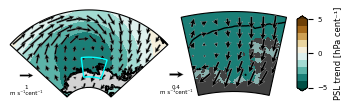

In [50]:
### Plot trends in ASL domain and AS_near domain

region_dict = {'ASL':[-80,-55,-160,-65.1], 'AS_near':[-76.5,-70,-120,-95]}
plot_data = [psl_trends, psl_trends_near] 
x_data = [u10_trends, u10_trends_near]
y_data = [v10_trends, v10_trends_near]
plot_regions = ['ASL','AS_near']

# Plot SLP trends in colors


fig = plt.figure()
fig.set_size_inches((3.5,1.5))
gs = GridSpec(1, 2, width_ratios=[1.5, 1])  # Set the width ratio: 3 times wider for the first subplot

for i in range(2):

    # get region domain
    plot_region = plot_regions[i]
    lat1,lat2,lon1,lon2 = region_dict[plot_region]
    lon1,lon2 = lon1+360, lon2+360
    recon_reg_psl = recon_psl_dict[recon].sel(lat = slice(lat1,lat2), lon=slice(lon1,lon2))
    lons_reg,lats_reg = recon_reg_psl.lon,recon_reg_psl.lat
    lon_mid = (lon1+lon2)/2

    # plot data
    ax = fig.add_subplot(gs[i],projection=ccrs.SouthPolarStereo(central_longitude=lon_mid))
    cf_em = ax.contourf(lons_reg, lats_reg,plot_data[i],transform=ccrs.PlateCarree(),
                        levels=np.linspace(-5,5,11), cmap=psl_cmap, zorder=0, extend = 'both')
    if i == 0:
        quiv = ax.quiver(lons_reg,lats_reg, x_data[i], y_data[i], transform = ccrs.PlateCarree(),regrid_shape=10,
                         pivot = 'middle',scale=12,width=0.01, headlength=3,headaxislength=2.5,
                         minshaft=1,edgecolor='gray', linewidth = 0.2,zorder=3)
        vec_len = 1
        ax.quiverkey(quiv, X=0.1, Y=0.25, U=vec_len, label=str(vec_len)+'\nm s⁻¹cent⁻¹', labelpos='S',fontproperties={'size':4})

        land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor='lightgray')
        ax.add_feature(land)
        ax.coastlines()

        # add rectangle to show AS box
        patch = make_arc_patch('AS_near','cyan',1)
        ax.add_patch(patch)
        
    else:
        quiv = ax.quiver(lons_reg,lats_reg, x_data[i], y_data[i], transform = ccrs.PlateCarree(),regrid_shape=8,
                         pivot = 'middle',scale=3,width=0.02, headlength=3,headaxislength=2.5,
                         minshaft=1,facecolor='k',edgecolor='lightgray', linewidth = 0.2,zorder=3)
        land_ice_ds = fda.get_bathymetry_and_troughs()
        lat2,lat1,lon1,lon2 = region_dict['AS_near']
        land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
        lons,lats = land_ice_ds.lon, land_ice_ds.lat
        blevs = (1200,)
        ax.contour(lons,lats,land_ice_ds.bathy, blevs, colors='k', transform=ccrs.PlateCarree(),
                   linewidths=1,zorder=1)
        ax.contourf(lons,lats,land_ice_ds.all_ice, transform=ccrs.PlateCarree(), colors=['lightgray']*2,
                    alpha=0.6,zorder=2)
        ax.contourf(lons,lats,land_ice_ds.grounded_ice, transform=ccrs.PlateCarree(), cmap='binary_r',
                    zorder=2)

        vec_len = 0.4
        ax.quiverkey(quiv, X=-0.05, Y=0.25, U=vec_len, label=str(vec_len)+'\nm s⁻¹cent⁻¹', labelpos='S',fontproperties={'size':4})

    # Set shape of map to match shape of data rather than a rectangle
    rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
    ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())


# # Add colorbar
cb_ax = fig.add_axes([0.83,0.25,0.03,0.5])
cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'vertical')  
cb_em.set_label(label = 'PSL trend [hPa cent⁻¹]', fontsize=6)
cb_em.set_ticks([-5,0,5])
cb_em.ax.tick_params(labelsize=5)


# plt.suptitle('Reconstructed 20th century trends', fontsize=7)
fig.subplots_adjust(left=0.01,right=0.8,top=0.98,bottom=0.02,wspace=0.1,hspace=.05)

plt.savefig('Plots/Figure_5bc_recon_trends_'+recon+'.png',dpi=600)

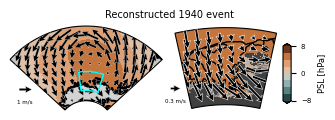

In [181]:
### Plot 1940 event 


plot_regions = ['ASL','AS_near']

fig = plt.figure()
fig.set_size_inches((3.25,1.2))
gs = GridSpec(1, 2, width_ratios=[1.5, 1])  # Set the width ratio: 3 times wider for the first subplot

for i in range(2):

    # get region domain
    plot_region = plot_regions[i]
    lat1,lat2,lon1,lon2 = region_dict[plot_region]
    lon1,lon2 = lon1+360, lon2+360
    recon_reg_psl = recon_psl_dict[recon].sel(lat = slice(lat1,lat2), lon=slice(lon1,lon2))
    recon_1940_psl = recon_reg_psl.sel(time=1940).squeeze()
    recon_reg_u10 = recon_u10_dict[recon].sel(lat = slice(lat1,lat2), lon=slice(lon1,lon2))
    recon_1940_u10 = recon_reg_u10.sel(time=1940).squeeze()
    recon_reg_v10 = recon_v10_dict[recon].sel(lat = slice(lat1,lat2), lon=slice(lon1,lon2))
    recon_1940_v10 = recon_reg_v10.sel(time=1940).squeeze()
    lons_reg,lats_reg = recon_reg_psl.lon,recon_reg_psl.lat

    
    lon_mid = (lon1+lon2)/2

    # plot data
    ax = fig.add_subplot(gs[i],projection=ccrs.SouthPolarStereo(central_longitude=lon_mid))
    cf_em = ax.contourf(lons_reg, lats_reg, recon_1940_psl,transform=ccrs.PlateCarree(),
                        levels=np.linspace(-8,8,9), cmap=psl_cmap, zorder=0, extend = 'both')
    if i == 0:
        quiv = ax.quiver(lons_reg,lats_reg, recon_1940_u10, recon_1940_v10, transform = ccrs.PlateCarree(),regrid_shape=10,
                         pivot = 'middle',scale=12,width=0.015, headlength=3,headaxislength=2.5,
                         minshaft=1,edgecolor='white', linewidth = 0.2,zorder=3)
        vec_len = 1
        ax.quiverkey(quiv, X=0.1, Y=0.25, U=vec_len, label=str(vec_len)+' m/s', labelpos='S',fontproperties={'size':4})

        land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor='lightgray')
        ax.add_feature(land)
        ax.coastlines()

        # add rectangle to show AS box
        patch = make_arc_patch('AS_near','cyan',1)
        ax.add_patch(patch)
        
    else:
        quiv = ax.quiver(lons_reg,lats_reg, recon_1940_u10, recon_1940_v10, transform = ccrs.PlateCarree(),regrid_shape=8,
                         pivot = 'middle',scale=3,width=0.025, headlength=3,headaxislength=2.5,
                         minshaft=1,edgecolor='white', linewidth = 0.4,zorder=3)
        land_ice_ds = fda.get_bathymetry_and_troughs()
        lat2,lat1,lon1,lon2 = region_dict[region]
        land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
        lons,lats = land_ice_ds.lon, land_ice_ds.lat
        blevs = (500,1000)
        ax.contour(lons,lats,land_ice_ds.bathy, blevs, colors='k', transform=ccrs.PlateCarree(),
                   linewidths=1,zorder=1)
        ax.contourf(lons,lats,land_ice_ds.all_ice, transform=ccrs.PlateCarree(), colors=['lightgray']*2,
                    alpha=0.6,zorder=2)
        ax.contourf(lons,lats,land_ice_ds.grounded_ice, transform=ccrs.PlateCarree(), cmap='binary_r',
                    zorder=2)

        vec_len = 0.3
        ax.quiverkey(quiv, X=0, Y=0.25, U=vec_len, label=str(vec_len)+' m/s', labelpos='S',fontproperties={'size':4})

    # Set shape of map to match shape of data rather than a rectangle
    rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
    ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())


# # Add colorbar
cb_ax = fig.add_axes([0.85,0.2,0.025,0.5])
cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'vertical')  
cb_em.set_label(label = 'PSL [hPa]', fontsize=6)
cb_em.set_ticks([-8,0,8])
cb_em.ax.tick_params(labelsize=5)


plt.suptitle('Reconstructed 1940 event', fontsize=7)
fig.subplots_adjust(left=0.01,right=0.83,top=0.94,bottom=0.05,wspace=0.1,hspace=.05)

# plt.savefig('Plots/Figure_4de_recon_1940_event_'+recon+'.png',dpi=600)